#Expected Sarsa

## Code

In [ ]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.losses import mean_squared_error
from keras.layers import Dense
from keras.optimizers import SGD
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.memory = deque(maxlen=2000)
        self.gamma = 0.9
        self.epsilon = 0.1 
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        # Neural Net
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=mean_squared_error,
                      optimizer=SGD(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def e_greedy(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def seq_max(self, state):
        state = np.reshape(state, [1, state_size])
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.reshape(state, [1, state_size])
            target = self.model.predict(state)
        if done:
            target[0][action] = reward
        else:
            next_state = np.reshape(next_state, [1, state_size])
            action = self.e_greedy(next_state)
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + (self.gamma**4) * t[action]
        self.model.fit(state, target, epochs=2, batch_size=len(minibatch), verbose=0)

    def replay_test(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.reshape(state, [1, state_size])
            target = self.model.predict(state)
        if done:
            target[0][action] = reward
        else:
            next_state = np.reshape(next_state, [1, state_size])
            # action = self.e_greedy(next_state)
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + (self.gamma**4) * np.mean(t)
        self.model.fit(state, target, epochs=2, batch_size=len(minibatch), verbose=0)

Thoughts: In the class corresponding to agent, we build 2 exploration methods and 2 replay methods related to them. Recall from textbook that Q-learning is a 'unifying' method that combines properties of other TD method. Since here we are interested in 4-step, and that there are 2 modes of exploration, we can modularize the code so that 3 algorithms only differ by sequence of the 4 steps.

## Value computations

In [ ]:
if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    env = env.unwrapped
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    done = False
    batch_sizes = [50, 100, 250, 500]
    lrs = [0.01, 0.02, 0.05, 0.1]
    sequence = [True, True, True, True]
    EPISODES = 120
    master_dict = {}


    for batch_size in batch_sizes:
        print(batch_size)
        master_dict[str(batch_size)]= {}
        for learning_rate in lrs:
            print(learning_rate)
            master_dict[str(batch_size)][str(learning_rate)] = {}
            agent = DQNAgent(state_size, action_size, learning_rate)
            rewards = []
            for seed in range(1, 11):
                for e in range(EPISODES):
                    env.seed(seed)
                    random.seed(seed)
                    tf.random.set_random_seed(seed)
                    state_ = env.reset()
                    state = state_.copy()
                    state = np.reshape(state, [1, state_size])
                    discounted_reward = 0
                    total_reward = 0
                    while True:
                        for i,s in enumerate(sequence):
                            if s == True:
                                state = np.reshape(state, [1, state_size])
                                action = agent.e_greedy(state)
                            else: 
                                # if exp sarsa, it reurns q value, not action
                                action = agent.seq_max(state)
                            
                            next_state, reward, done, _ = env.step(action)
                            discounted_reward += (agent.gamma**i)*reward
                            total_reward += discounted_reward
                            if done: 
                                env.reset()
                                break;
                            state = next_state
                        next_state = np.reshape(next_state, [1, state_size])
                        agent.memorize(state_, action, discounted_reward, next_state, done)
                        if len(agent.memory) > batch_size:
                            if sequence[-1] == False:
                                # call one kindo freplay
                                agent.replay_test(batch_size)
                            else:
                                agent.replay(batch_size)
                    
                        if done:
                            break
                    rewards.append(total_reward)       
            split_rewards = np.array_split(rewards, 10) 
            reward_ave = np.mean(split_rewards, axis = 0)
            reward_ave_std = np.std(split_rewards, axis = 0)
            avg_reward = np.mean(reward_ave[-10:])
            std_reward = np.std(reward_ave[-10:])
            master_dict[str(batch_size)][str(learning_rate)]['mean'] = avg_reward
            master_dict[str(batch_size)][str(learning_rate)]['std'] = std_reward
            master_dict[str(batch_size)][str(learning_rate)]['raw'] = reward_ave
            master_dict[str(batch_size)][str(learning_rate)]['rawstd'] = reward_ave_std
        print("episode: {}/{}, score: {}".format(e, EPISODES, avg_reward))

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


50
0.01
0.02
0.05
0.1
episode: 119/120, score: 77.81182
100
0.01
0.02
0.05
0.1
episode: 119/120, score: 80.65970999999999
250
0.01
0.02
0.05
0.1
episode: 119/120, score: 74.46930999999998
500
0.01
0.02
0.05
0.1
episode: 119/120, score: 65.57088999999999


We try to build a 'master dictionary' that contains all information we need for plotting and analysis

We do notice the following when running:



1.   As replay buffer size increases, the training time increases rather significantly
2.   The hyper-parameter grid size is compromised due to the fact that Colab constantly automatically shutdown kernel or restart runtime, presumably due to heavy computation load


## Plotting

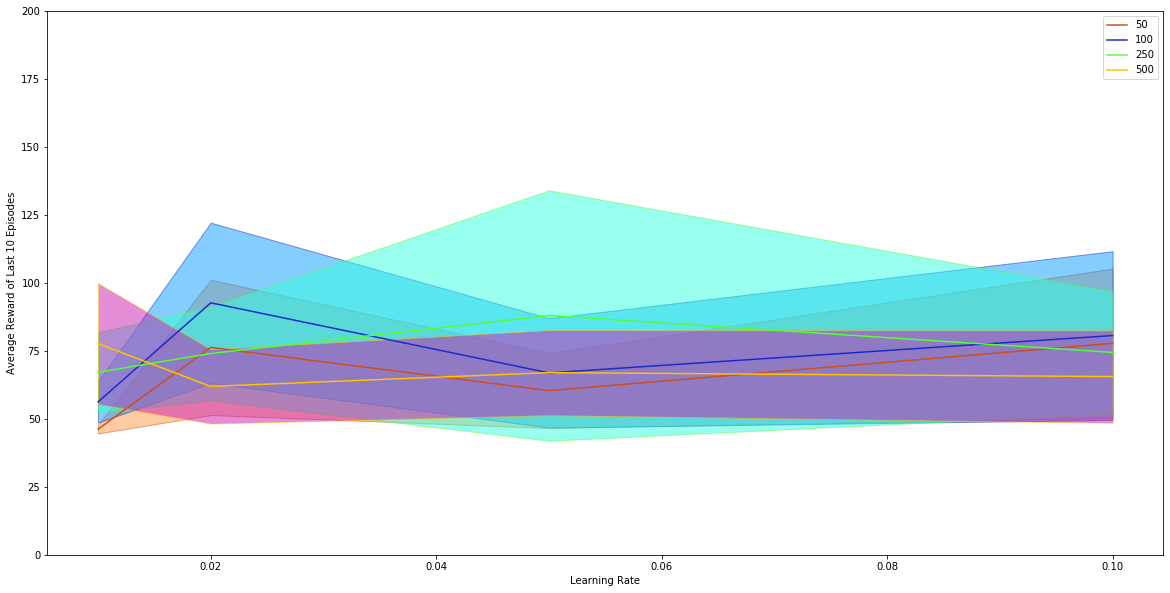

In [ ]:
import matplotlib.pyplot as plt

x_series = lrs
y_plots = []
y_errors = []

for key in master_dict:
    y_plot = []
    y_error = []
    for sub_key in master_dict[key]:
        y_plot.append(master_dict[key][sub_key]['mean'])
        y_error.append(master_dict[key][sub_key]['std'])
    y_plots.append(y_plot)
    y_errors.append(y_error)

fig, ax = plt.subplots(1, figsize=(20, 10))

ax.plot(x_series, y_plots[0], 'k', color='#CC4F1B', label = '50')
ax.legend()
ax.fill_between(x_series, np.asarray(y_plots[0]) + np.asarray(y_errors[0]), np.asarray(y_plots[0]) - np.asarray(y_errors[0]),
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

ax.plot(x_series, y_plots[1], 'k', color='#1B2ACC', label = '100')
ax.legend()
ax.fill_between(x_series, np.asarray(y_plots[1]) + np.asarray(y_errors[1]), np.asarray(y_plots[1]) - np.asarray(y_errors[1]),
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')

ax.plot(x_series, y_plots[2], 'k', color='#52FF33', label='250')
ax.legend()
ax.fill_between(x_series, np.asarray(y_plots[2]) + np.asarray(y_errors[2]), np.asarray(y_plots[2]) - np.asarray(y_errors[2]),
    alpha=0.5, edgecolor='#52FF33', facecolor='#33FFE0')

ax.plot(x_series, y_plots[3], 'k', color='#FFC300', label='500')
ax.legend()
ax.fill_between(x_series, np.asarray(y_plots[3]) + np.asarray(y_errors[3]), np.asarray(y_plots[3]) - np.asarray(y_errors[3]),
    alpha=0.5, edgecolor='#FFC300', facecolor='#C81DB1')
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Average Reward of Last 10 Episodes")
ax.set_ylim([0, 200])
plt.show()

Above shows the plot of a hyperparameter grid search which compares the return of the last 10 episodes of 4-step Sarsa, ran on 10 seeds and averaged out. The hyperparameter sets are: Learning rate (0.01, 0.02, 0.05, 0.1), Replay buffer size (50, 100, 250, 500)

In the assignment instructions, we are asked to run with 20 seeds. However, the running time was so long that Google disconnected the notebook runtimes automatically. After few experiments, we settled with 10 seeds. This explains the 'wide' standard deviation error band. In practice, we should always run with many seeds so as to ensure reproducibility of experiments. We offer our sincerest apology for the quality of this result due to limitations beyond our control. 

Observations

---
For Sarsa, we can see that at large Buffer Size does not improve performance as learning rate increases. For both 250 and 500, as learning rate increases, the reward actually decrease slightly. 500 never improved beyond the lowest learning rate, while 250 topped out at 0.05 when giving the best performance of this comparison before tapering off.

Conversely, for smaller buffer sizes, we see the same trend: Both start as the worst for lowest learning rate, before improving when learning rate goes up to 0.02 (best at this rate), then taper offer before recover slightly when learning rate increased to 0.1.

However, it is still worthy investigating the effect of larger learning rate would play. On another hand, the settings within the neural network are also worth taking a look. For instance, we are using a fixed learning rate using SGD optimizer. If we try some adaptive methods where we could vary learning rates, things may be different.

Also notice that the results are much better in terms of standard deviation error band. This is a proof that with more seed it gets better.


Please note that the reason for not trying big learning rate is that since we were resource-limited, we tried to make the hyperparameter grid to be as compact as possbile, so transitions between different values are more sensical.

###Plot 2: Best combination of learning rate/replay buffer => Plot episodes vs return


As we can see, when we have [learning rate, replay buffer] == [0.05, 500], we get the best results.

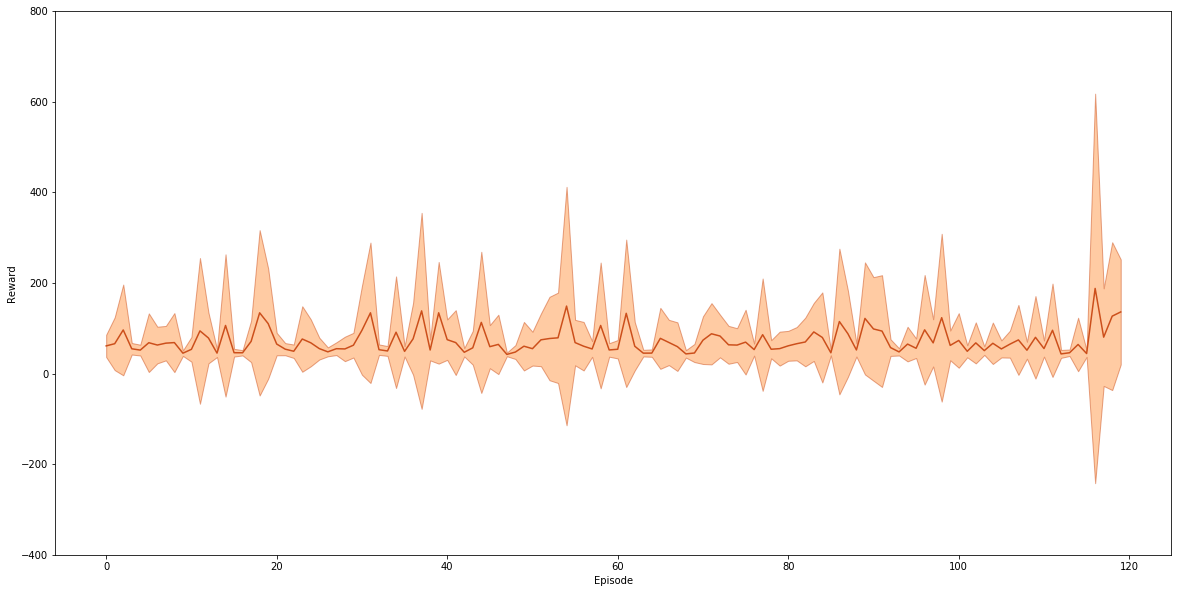

In [ ]:
x_series = np.arange(EPISODES)
y_series = master_dict['250']['0.05']['raw']
y_series_error = master_dict['250']['0.05']['rawstd']

fig, ax = plt.subplots(1, figsize=(20,10))
ax.plot(x_series, y_series, 'k', color='#CC4F1B', label = 'Buffer Size = 250')
ax.fill_between(x_series, y_series + y_series_error, y_series - y_series_error,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
ax.set_ylim([-400, 800])
ax.set_xlabel("Episode")
ax.set_ylabel("Reward")
plt.show()


Throughout the whole training process, we can see that convergence was reached very quickly, although there was some fluctuations.